<a href="https://colab.research.google.com/github/ZetaRR/Forbes-classification-of-billionaires/blob/main/ForbesBinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disclaimer


PLEASE OPEN IT IN GOOGLE COLAB NOTEBOOK. BECAUSE GITHUB HAVE PROBLEMS WITH DISPLAYING PLOTLY PLOTS/MAPS/SHAP AND OTHER VISUALIZATION PACKAGES 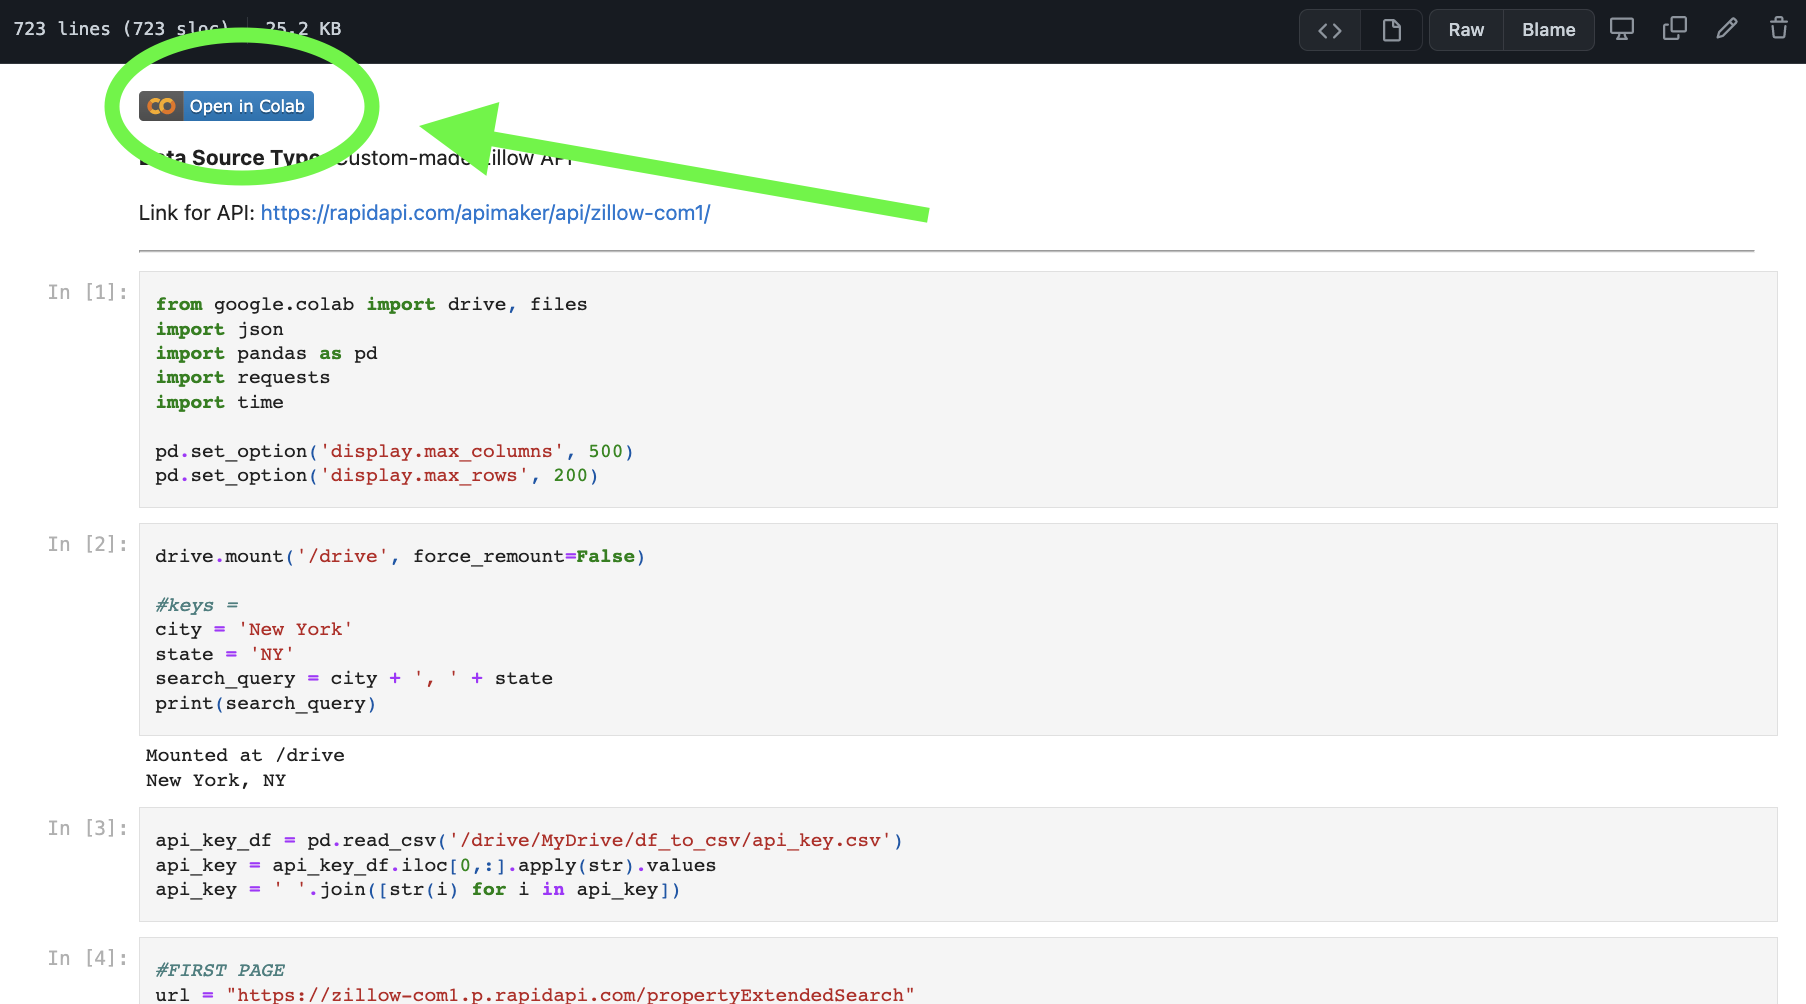

In [1]:
!pip install --upgrade pandas
!pip install catboost
!pip install shap

     |████████████████████████████████| 76.6 MB 51 kB/s 
     |████████████████████████████████| 564 kB 5.0 MB/s 


In [2]:
import os 
from google.colab import drive,files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as FF
from plotly import tools
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import missingno as msno
from datetime import datetime
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = "monospace"
init_notebook_mode(connected=True)

color_library = ['#B2BEB5', '#7393B3', '#36454F', '#A9A9A9', '#6082B6', '#808080',
          '#D3D3D3', '#899499', '#E5E4E2', '#8A9A5B', '#C0C0C0', '#708090',
          '#848884', '#71797E']

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%matplotlib inline

print("Mounting Google Drive:\n")
drive.mount('/drive', force_remount=False)

Mounting Google Drive:

Mounted at /drive


# Structure Investigation

In [3]:
df = pd.read_csv("/drive/MyDrive/forbes/forbes_data.csv")
df = df.rename(columns={'category':'industry'})

print("DataFrame shape --> ", df.shape)
print("Number of dimensions --> ", df.ndim)

df.sample(3).style.background_gradient(axis=0, cmap='Purples')

DataFrame shape -->  (294, 10)
Number of dimensions -->  2


,finalWorth,age,country,city,countryOfCitizenship,selfMade,status,gender,philanthropyScore,industry
171,4500,80.000000,United States,Little Jackson Hole,United States,True,U,M,3.000000,Finance & Investments
104,5900,72.000000,Taiwan,Taipei,Taiwan,True,U,M,nan,Technology
53,8100,57.000000,United States,San Francisco,United States,True,D,M,3.000000,Technology


*Viewing memory usage of given dataframe by columns*

In [4]:
df_memory_used = pd.DataFrame(df.memory_usage()).reset_index().rename(columns={'index':'variableType', 0:"count in bytes"})
df_memory_used.style.background_gradient(axis=0, cmap='BuPu')

,variableType,count in bytes
0,Index,128
1,finalWorth,2352
2,age,2352
3,country,2352
4,city,2352
5,countryOfCitizenship,2352
6,selfMade,294
7,status,2352
8,gender,2352
9,philanthropyScore,2352


In [5]:
numerical_columns = [i for i in df.columns if df[i].dtype in ['float64','int64']]

print("Num of numerical columns:", len(numerical_columns))
print("*" * 100)
print("Numerical columns:\n", numerical_columns)

Num of numerical columns: 3
****************************************************************************************************
Numerical columns:
 ['finalWorth', 'age', 'philanthropyScore']


In [6]:
categorical_columns = [i for i in df.columns if df[i].dtype in ['O']]

print("Num of categorical columns:", len(categorical_columns))
print('*' * 100)
print("Categorical columns:\n", categorical_columns)


Num of categorical columns: 6
****************************************************************************************************
Categorical columns:
 ['country', 'city', 'countryOfCitizenship', 'status', 'gender', 'industry']


In [7]:
df.describe(include='all').T.style.background_gradient(axis=0, cmap='BuPu')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
finalWorth,294.000000,nan,nan,nan,5891.496599,3041.100002,2800.000000,3625.000000,4900.000000,6900.000000,16700.000000
age,290.000000,nan,nan,nan,61.682759,14.000595,28.000000,53.000000,60.500000,71.000000,95.000000
country,294,36,United States,160,nan,nan,nan,nan,nan,nan,nan
city,287,134,New York,33,nan,nan,nan,nan,nan,nan,nan
countryOfCitizenship,294,39,United States,153,nan,nan,nan,nan,nan,nan,nan
selfMade,294,2,True,249,nan,nan,nan,nan,nan,nan,nan
status,294,4,U,165,nan,nan,nan,nan,nan,nan,nan
gender,292,2,M,272,nan,nan,nan,nan,nan,nan,nan
philanthropyScore,124.000000,nan,nan,nan,1.975806,1.007805,1.000000,1.000000,2.000000,2.000000,5.000000
industry,294,2,Finance & Investments,164,nan,nan,nan,nan,nan,nan,nan


**Notable Points 📝:**

From plot it could be said that main part of features has `object` dtype, while all other `int64`.`bool` could be added to `object` dtype.

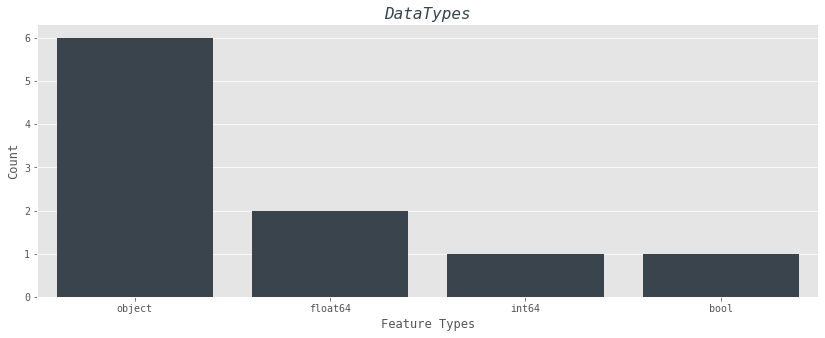

In [8]:
plt.figure(figsize=(14,5))
dataTypes = pd.DataFrame(df.dtypes.value_counts()).reset_index().rename(columns={'index':'variableType', 0:"count"})

sns.barplot(data=dataTypes, 
            x='variableType', 
            y="count",
            color=color_library[2])
plt.title('DataTypes', 
          color=color_library[2], 
          fontsize=16,
          style='italic')
plt.xlabel('Feature Types')
plt.ylabel('Count')

plt.show();

**Missing values**

In [9]:
def missing_df(df):
  total = df.isnull().sum().sort_values(ascending= False)
  Percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending= False)
  return pd.concat([total, Percentage], axis=1, keys=['Total', '%'])

missing_df(df)[missing_df(df)['%']!=0].style.background_gradient(cmap="Purples")

,Total,%
philanthropyScore,170,57.823129
city,7,2.380952
age,4,1.360544
gender,2,0.680272


Text(0.5, 1.0, 'Sorted matrix by philanthropyScore')

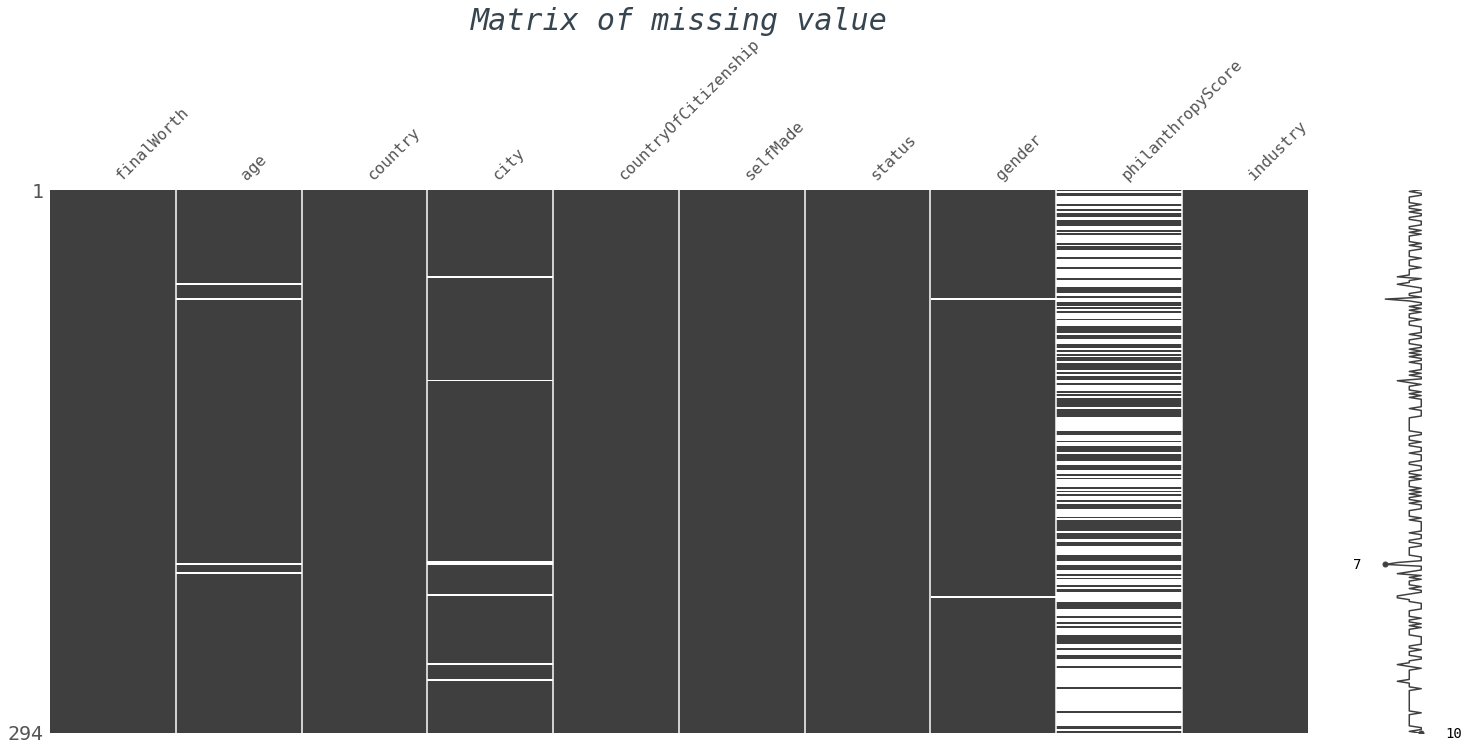

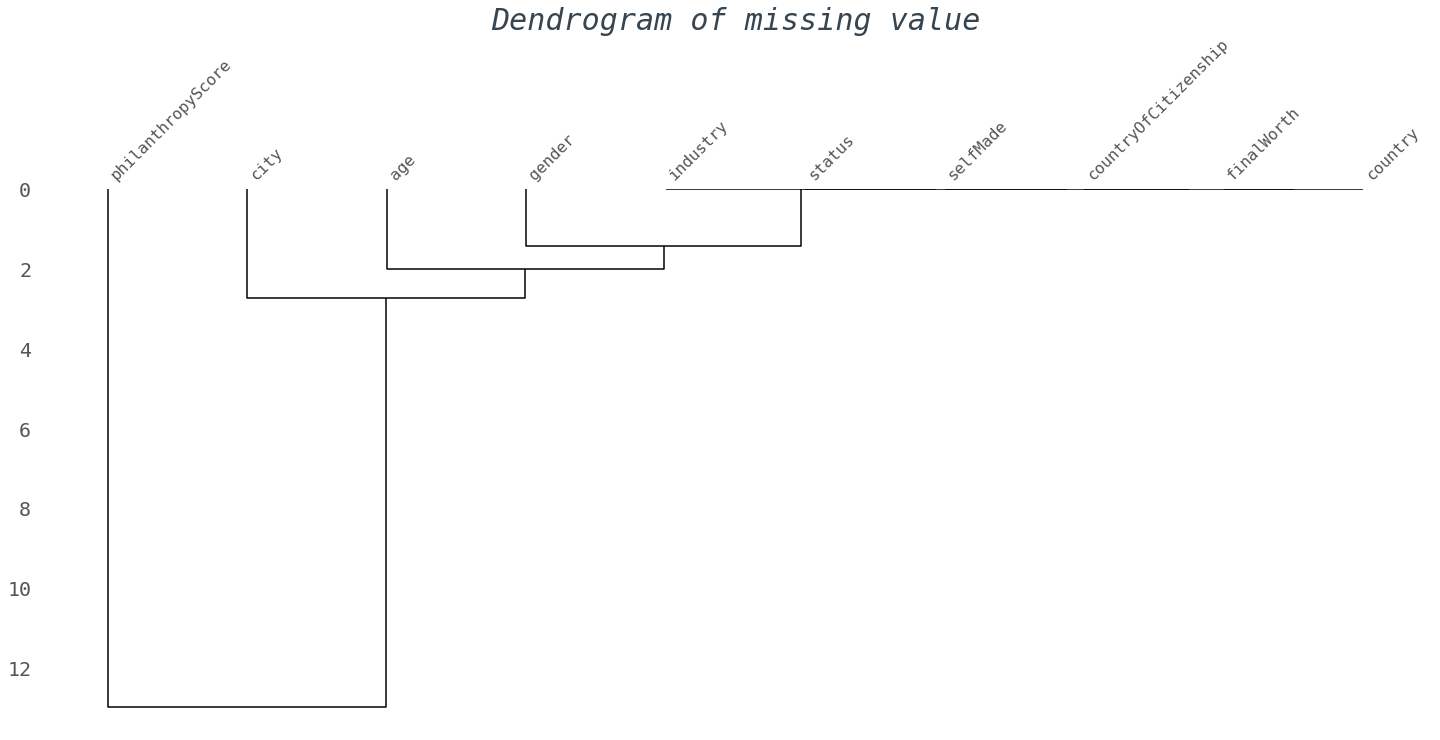

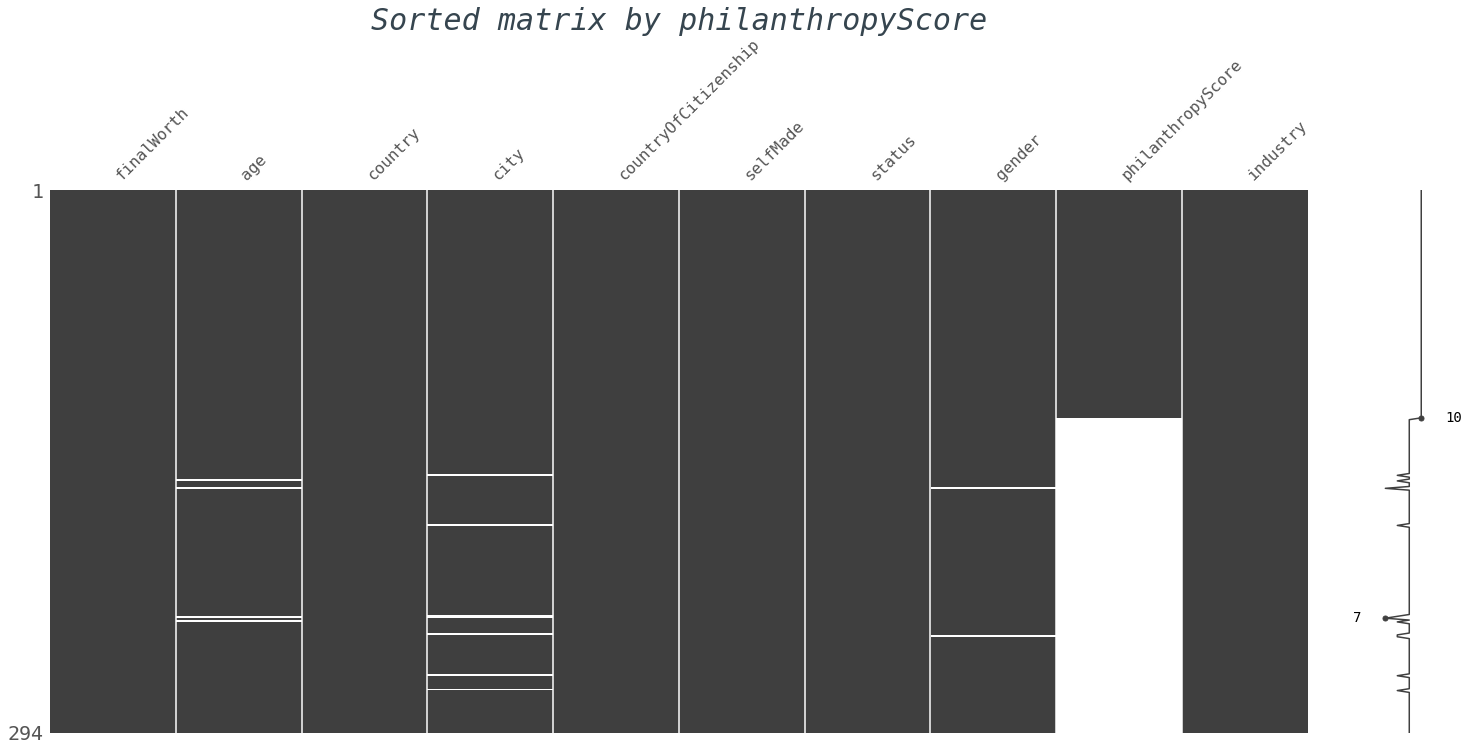

In [10]:
msno.matrix(df)
plt.title('Matrix of missing value',fontsize=30, fontweight=10, color=color_library[2], style='italic')

msno.dendrogram(df) # checking how missing values in columns are correlated with other columns 
plt.title('Dendrogram of missing value',fontsize=30, fontweight=10, color=color_library[2], style='italic')

msno.matrix(df.sort_values(by="philanthropyScore")) # checking NA nature. Is it Missing at Random?
plt.title('Sorted matrix by philanthropyScore', fontsize=30, fontweight=10, color=color_library[2], style='italic')

**Notable Points 📝:**

By using *missigno* package and by manually going through rows with missing values, it is obvious that values are *Missing Not At random*. Therefore, it will be easier and more efficient to just drop rows with missing values, as there would be encountred some problems with too many different variables in categorical columns to impure, such as `city`.

In [11]:
print('Shape before dropping NA -- > ', df.shape)

df = df.drop('philanthropyScore', axis=1)
df.dropna(how='any', inplace=True)

print('*'*100)
print('Shape after dropping NA -- > ', df.shape)

Shape before dropping NA -- >  (294, 10)
****************************************************************************************************
Shape after dropping NA -- >  (283, 9)


In [12]:
df.rename(columns={'finalWorth': 'final_worth', # fixing feature names
                   'countryOfCitizenship': 'country_of_citizenship',
                   'selfMade':'self_made',
                   'industry':'target'},
          inplace=True, errors='ignore')

df['age'] = df['age'].astype('int64') # fixing dtypes
df['self_made'] = df['self_made'].astype('object')
df['gender'] =  df['gender'].replace({'M':'Male', 'F':'Female'})
df[df.duplicated()]

,final_worth,age,country,city,country_of_citizenship,self_made,status,gender,target
205,4000,40,United States,New York,United States,True,U,Male,Finance & Investments


In [13]:
df.drop(205, inplace=True)
df[df.duplicated()]

,final_worth,age,country,city,country_of_citizenship,self_made,status,gender,target


In [14]:
round(df.describe(exclude = ['float', 'int64']),2).T.style.set_properties(**{"background-color": "#7393B3", "color": "black", "border-color": "black","font-size":"11pt",'width': 250})

,count,unique,top,freq
country,282,34,United States,159
city,282,132,New York,32
country_of_citizenship,282,37,United States,151
self_made,282,2,True,241
status,282,4,U,160
gender,282,2,Male,263
target,282,2,Finance & Investments,157


# Exploratory Data Analysis (EDA) 🎮 

**Distribution of target**

**Notable Points 📝:**
From plot presented below, it could be noticed that imbalance is present among all three values in `target` column. Therefore, after EDA imbalance should be taken care of, and solved with Oversampling/Undersampling, to decide what to use - it would requrie further exploration of dataset.

In [15]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Barplot', 'Percentages %'),
                    specs=[[{"type": "xy"},
                            {'type':'domain'}]])

barplot = fig.add_trace(go.Bar(y=df['target'].value_counts().values.tolist(),
                               x=df['target'].value_counts().index,
                               text=df['target'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 1,col = 1)

pieplot = fig.add_trace((go.Pie(labels=df['target'].value_counts().keys(),
                             values=df['target'].value_counts().values,textfont = dict(size = 16),
                             hole = .5,
                            marker=dict(colors=color_library,
                            line_color = 'black',
                            line_width=2),
                            textinfo='label')), row = 1, col = 2)

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title=dict(text='Distribution of Industries(Targets)'),
                  title_font_size=28, font_family="monospace")

fig.show(renderer="colab")

**Distribution of categorical features:**

**Notable Points 📝:**

In the first rows of code block below, masking could be seen made for some features in order to create better plotting and give more precise picture. However, the same steps could be done latter in the feature engineering section, and right now it is only done temporary just to not mix both EDA and feature engineering. Talking about plot itself, majority of billionaires are from USA and have USA citizenship, while also good amount of billionaires from China. Also, vast majority of billionaires and millionaires are self made, which looks very interesting. Talking about genders, with big difference male is the majority among gender list. Finally, talking about cities, it is easy to spot that billionaires and millionaires really like to live in New York, San Francisco, London, Hong Kong, but this could not be fully trusted infromation, as it is biased by factors and features mentioned above. Also, 'other' column is not reviewed and counted in factors as it just consists of other small fraction, that is why it have big part among other features.


In [16]:
temp_df = df.copy() # used to mask small values during plotting
mask_country = temp_df.groupby('country').country.transform('size') < 8
temp_df.loc[mask_country, 'country'] = 'Other countries'

mask_country_citizenship = temp_df.groupby('country_of_citizenship').country_of_citizenship.transform('size') < 6
temp_df.loc[mask_country_citizenship, 'country_of_citizenship'] = 'Other citizenships'

mask_city = temp_df.groupby('city').city.transform('size') < 6
temp_df.loc[mask_city, 'city'] = 'Other cities'


fig = make_subplots(rows=3, cols=2, subplot_titles=('Country distribution',
                                                    'Country of citizenship distribution',
                                                    'Self Made distribution',
                                                    'Status distribution',
                                                    'Gender distribution',
                                                    'City distirbution'))
fig.add_trace(go.Bar(y=temp_df['country'].value_counts().values.tolist(),
                               x=temp_df['country'].value_counts().index,
                               text=temp_df['country'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 1,col = 1)

fig.add_trace(go.Bar(y=temp_df['country_of_citizenship'].value_counts().values.tolist(),
                               x=temp_df['country_of_citizenship'].value_counts().index,
                               text=temp_df['country_of_citizenship'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 1,col = 2)

fig.add_trace(go.Bar(y=df['self_made'].value_counts().values.tolist(),
                               x=df['self_made'].value_counts().index,
                               text=df['self_made'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 2,col = 1)

fig.add_trace(go.Bar(y=df['status'].value_counts().values.tolist(),
                               x=df['status'].value_counts().index,
                               text=df['status'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 2,col = 2)

fig.add_trace(go.Bar(y=df['gender'].value_counts().values.tolist(),
                               x=df['gender'].value_counts().index,
                               text=df['gender'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 3,col = 1)

fig.add_trace(go.Bar(y=temp_df['city'].value_counts().values.tolist(),
                               x=temp_df['city'].value_counts().index,
                               text=temp_df['city'].value_counts().values.tolist(),
                               textfont=dict(size=15),
                               textposition = 'outside',
                               showlegend=False,
                               marker = dict(color = color_library,
                                            line_color = 'black',
                                            line_width=2)),row = 3,col = 2)

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title=dict(text='Distribution of categorical features'),
                  title_font_size=28, font_family="monospace",
                  width=1200,
                  height=1650,
                  showlegend=True)

fig.show(renderer="colab")

**Distribution of numerical features:**

**Notable Points 📝:**

`final_worth` - Looks highly negatively skewed

`age feature` - Gaussian distribution

In [17]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Net Worth Distribution', 'Age Distribution'))

fig.add_trace(go.Histogram(x=df['final_worth'] ,marker = dict(color = color_library[4],
                            line_color = 'black',
                            line_width=3)), row=1, col=1)

fig.add_trace(go.Histogram(x=df['age'],marker = dict(color = color_library[3],
                            line_color = 'black',
                            line_width=3)), row=1, col=2)

fig.update_layout(bargap=0.1,
                  paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title=dict(text='Distribution of numerical features'),
                  title_font_size=28, font_family="monospace",
                  width=1800,
                  height=500,
                  showlegend=False)

fig.show(renderer='colab')

**Segmenting the target variable by categorical features**

**Notable Points 📝:**

`Target VS Country` - It could be seen that Finance & Investment industry are leading in all countries, except China, where vast majority is presented by Technology sector

`Target VS City` - Situtation with leading of industry differs from city to city, while it should be noticed that in New York that Finance & Investment is leading much more

`Target VS Country of citizenship` - Finance & Investment section is leading, except China, where Technological sector makes vast majority

`Target VS Self Made` - Self made billionaires have small difference in amount betweem two sectors.

`Target VS Gender` - Females consists vast majority in Technological sector, while Males makes majority in Finance & Investment 

In [18]:
def target_by_cat(temp_df, title, feature):
  fig = px.histogram(temp_df, x=feature ,
                   color ="target", 
                   pattern_shape="target", 
                   barmode='group',
                   color_discrete_sequence={
                0: "#808080",
                1: "#E5E4E2"})

  fig.update_layout(bargap=0.2,
                  paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title=dict(text=title),
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=350,
                  showlegend=False)

  fig.show(renderer='colab')

target_by_cat(temp_df, 'Target VS Country', 'country')
target_by_cat(temp_df, 'Target VS City', 'city')
target_by_cat(temp_df, 'Target VS Country of citizenship', 'country_of_citizenship')
target_by_cat(temp_df, 'Target VS Self Made', 'self_made')
target_by_cat(temp_df, 'Target VS Status', 'status')
target_by_cat(temp_df, 'Target VS Gender', 'gender')

**Status VS Target / Gender VS Target**

In [19]:
fig = go.Figure(data=[go.Box(y=temp_df['status'], x=temp_df['target'], opacity=0.95, 
                             showlegend=False, 
                             name='Cooling VS Price',
                             boxpoints='all',
                             jitter=0.6,
                             whiskerwidth=0.2,
                             marker_size=2,
                             line_width=1,
                             marker_color='#6082B6')])

fig.update_layout(bargap=0.2,
                  paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title=dict(text="Status VS Target"),
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=350,
                  showlegend=False)



fig.show(renderer='colab')


fig = go.Figure(data=[go.Box(x=temp_df['gender'], y=temp_df['target'], opacity=0.95, 
                             showlegend=False, 
                             name='Cooling VS Price',
                             boxpoints='all',
                             jitter=0.6,
                             whiskerwidth=0.2,
                             marker_size=2,
                             line_width=1,
                             marker_color='#8A9A5B')])

fig.update_layout(bargap=0.2,
                  paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title=dict(text="Gender VS Target"),
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=350,
                  showlegend=False)



fig.show(renderer='colab')

**Comparing categorical variables with numerical variables**

In [20]:
for column in df.select_dtypes(include='object'):
    if df[column].nunique() < 10:
      print('*'*100)
      display(df.groupby(column).mean())

****************************************************************************************************


,final_worth,age
self_made,,
False,5602.439024,67.853659
True,5982.572614,60.863071


****************************************************************************************************


,final_worth,age
status,,
D,6819.047619,59.333333
E,5169.565217,62.826087
N,5453.333333,47.866667
U,5612.500000,64.393750


****************************************************************************************************


,final_worth,age
gender,,
Female,6531.578947,62.473684
Male,5883.650190,61.836502


****************************************************************************************************


,final_worth,age
target,,
Finance & Investments,5626.11465,64.66242
Technology,6305.60000,58.38400


# Correlationship Analysis 🎲

**Analysis of age distribution and correlationship of self_made, gender**

`Distribution of age by Self Made feature` - distribution of both self made and not self_made Forbes member looks pretty identical, while both distributions represent gaussian distribution. However, there are little changes between both distributions. It could be seen that self made billionaires tend to be the majority during 0-30 years old, and there is no billionaires that are below 30 years old that are not self-made in this dataframe, on the other hand, vast majority of billionaires after 70 years old are tend to be not self made, possibly that that people inherited big family businesses.

`Distribution of age by Gender` - both distributions repeat Gaussian distribution, but Male are much more spreaded along all age distributions. Some gaps are noticed, due to not having enough Female values.

In [21]:
fig = px.histogram(df, 
                   x='age', 
                   color='self_made', 
                   opacity=0.7, 
                   barmode='overlay',
                   histnorm='probability density',
                   marginal='box',
                   title='Distribution of age by Self Made feature',
                   color_discrete_sequence=[color_library[0],color_library[4]])

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

fig = px.histogram(df, 
                   x='age', 
                   color='gender', 
                   opacity=0.7, 
                   barmode='overlay',
                   histnorm='probability density',
                   marginal='box',
                   title='Distribution of age by Gender',
                   color_discrete_sequence=[color_library[0],color_library[4]])

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)


fig.show(renderer='colab')

**Analysis of net worth distribution and correlationship of self_made, gender**

`Distribution of Networth by Self Made feature` - Self made people tend to have bigger net worth.

`Distribution of Networth by Gender` - Both Male and Female looks to have log distribution.Once more it is verified that Males in this dataframe has bigger net worths.

In [22]:
fig = px.histogram(df, 
                   x='final_worth', 
                   color='self_made', 
                   opacity=0.7, 
                   barmode='overlay',
                   histnorm='probability density',
                   marginal='box',
                   title='Distribution of Networth by Self Made feature',
                   color_discrete_sequence=[color_library[0],color_library[4]])

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)
fig.show(renderer='colab')

fig = px.histogram(df, 
                   x='final_worth', 
                   color='gender', 
                   opacity=0.7, 
                   barmode='overlay',
                   histnorm='probability density',
                   marginal='box',
                   title='Distribution of Networth by Gender',
                   color_discrete_sequence=[color_library[0],color_library[4]])

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

**Correlationship Final Worth VS Age**

**Notable Points 📝:**

It is hard to notice any linear correlationship between both `final_worth` and `age` feature. Worth to mention, that with age there tend to be more rich people with higher net worth, which makes sense. As *TIME=MONEY.* From given plot, hard to determine any correlationship with `status` feature.



In [23]:
fig = px.scatter(df, 
                 x='age', 
                 y='final_worth', 
                 color='status', 
                 size='final_worth',
                 title='Final Worth VS Age',
                 color_discrete_sequence=[color_library[1], color_library[2], color_library[7],
                                          color_library[9]])

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

**Average `Age` by `Status`, Average` Net worth` by `Gender`, Average `Net worth` by `Self Made`**

**Notable Points 📝:**

`Average Age by Status` - it could be seen that billionaires with U status have the biggest age, while on the other hand, billionaires with N status have the lowest age with big spread between the biggest and smallest age.

`Average Net worth by Gender` - Female in average have bigger mean net worth.

`Average Net worth by Self Made` - Self Made billionaires have bigger mean net worth.


In [24]:
plot_df = pd.DataFrame(df.groupby('status')['age'].mean())
plot_df = plot_df.reset_index()

fig = px.bar(plot_df, x='status', y='age',height=800, color='status',
             title='Average Age by Status',
             text='age', opacity=0.85,
             color_discrete_map={'D':color_library[1], 'E':color_library[2],
                                 'N':color_library[3], 'U':color_library[6],
                                 'Split Family Fortune':color_library[7]})
fig.update_traces(texttemplate='Mean age %{text:,0.f}',
                  textposition='outside',
                  marker_line=dict(width=1, color='#303030'))
fig.update_xaxes(title="Status")
fig.update_yaxes(title="Mean Age")

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

plot_df = pd.DataFrame(df.groupby('gender')['final_worth'].mean())
plot_df = plot_df.reset_index()

fig = px.bar(plot_df, x='gender', y='final_worth',height=800, color='gender',
             title='Average Net worth by Gender',
             text='final_worth', opacity=0.85,
             color_discrete_map={'Female':color_library[1], 'Male':color_library[2]})
fig.update_traces(texttemplate='Mean networth %{text:,0.f}',
                  textposition='outside',
                  marker_line=dict(width=1, color='#303030'))
fig.update_xaxes(title="Gender")
fig.update_yaxes(title="Mean networth")

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

plot_df = pd.DataFrame(df.groupby('self_made')['final_worth'].mean())
plot_df = plot_df.reset_index()

fig = px.bar(plot_df, x='self_made', y='final_worth',height=800, color='self_made',
             title='Average Net worth by Self Made',
             text='final_worth', opacity=0.85,
             color_discrete_map={True:color_library[2], False:color_library[1]})
fig.update_traces(texttemplate='Mean networth %{text:,0.f}',
                  textposition='outside',
                  marker_line=dict(width=1, color='#303030'))
fig.update_xaxes(title="Self Made")
fig.update_yaxes(title="Mean networth")

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')





**Numerical columns by Target feature**

**Notable Points 📝:**

`Average Age by Industry `- In Financial sector age of billionaires is higher than in Technological sector. It looks totally logical, as Financial sector appeared long time ago, while Technological sector compared with other industries appeared much more later than Financial sector.

`Average Networth by Industry` - Mean Networth in Technological industry is higher than in Financial industry.

In [25]:
plot_df = pd.DataFrame(df.groupby('target')['age'].mean())
plot_df = plot_df.reset_index()

fig = px.bar(plot_df, x='target', y='age',height=800, color='target',
             title='Average Age by Industry',
             color_discrete_map={'Finance & Investments': '#BFC5DA',
                                 'Technology':'#E5E4E2'},
             text='age', opacity=0.85)
fig.update_traces(texttemplate='Mean age %{text:,0.f}',
                  textposition='outside',
                  marker_line=dict(width=1, color='#303030'))
fig.update_xaxes(title="Industry")
fig.update_yaxes(title="Mean Age")

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

plot_df = pd.DataFrame(df.groupby('target')['final_worth'].mean())
plot_df = plot_df.reset_index()

fig = px.bar(plot_df, x='target', y='final_worth',height=800, color='target',
             title='Average Networth by Industry',
             color_discrete_map={'Finance & Investments': '#BFC5DA',
                                 'Technology':'#E5E4E2'},
             text='final_worth', opacity=0.85)
fig.update_traces(texttemplate='Mean networth %{text:,0.f}',
                  textposition='outside',
                  marker_line=dict(width=1, color='#303030'))
fig.update_xaxes(title="Industry")
fig.update_yaxes(title="Mean Networth")

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28, font_family="monospace",
                  width=1300,
                  height=700,
                  showlegend=False)

fig.show(renderer='colab')

# Preprocessing dataframe for building models 🎚

`'Finance & Investments'` = 0  

`'Technology`'= 1

In [26]:
df_model = df.copy()
df_model['target'] =  df_model['target'].replace({'Finance & Investments':0, 'Technology':1}) # encoding target feature
df_model.drop('country_of_citizenship', axis=1, inplace=True)

mask_country = df_model.groupby('country').country.transform('size') < 7
df_model.loc[mask_country, 'country'] = 'Other countries'

mask_city = df_model.groupby('city').city.transform('size') < 8
df_model.loc[mask_city, 'city'] = 'Other cities'

**Encoding**

In [27]:
X = df_model.drop(['target'], axis=1)
y = df_model.target

cat_cols = ['country', 'city', 'self_made', 'status', 'gender']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(X[cat_cols])
encoded_cols = list(encoder.get_feature_names(cat_cols))
X[encoded_cols] = encoder.transform(X[cat_cols])
X.drop(cat_cols, axis=1, inplace=True)
pd.DataFrame(X, columns=X.columns)

,final_worth,age,country_China,country_Other countries,country_Taiwan,country_United Kingdom,country_United States,city_Beijing,city_New York,city_Other cities,city_San Francisco,city_Shenzhen,city_Taipei,self_made_False,self_made_True,status_D,status_E,status_N,status_U,gender_Female,gender_Male
0,16700,64,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,16600,54,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,16500,86,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,16400,58,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,15300,42,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2900,59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
290,2900,65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
291,2900,66,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
292,2800,76,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Scailing**

For Scailing StandardScaler would be used, in order to not down influence of outliers in dataframe.

In [28]:
num_cols = ['final_worth', 'age']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
#-----------------------------
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test:",  y_test.shape)

Shape of X_train:  (225, 21)
Shape of X_test:  (57, 21)
Shape of y_train:  (225,)
Shape of y_test: (57,)


# Balancing dataframe ⚖️

As it could be seen that target feature is disbalanced, therefore it should be balanced. SMOTE package would be used for it, and oversampling tehcnique. As given dataframe is small, therefore downsampling could not be used. to cut more already small data.

In [29]:
print("Before OverSampling, counts of label 'Finance & Investments': {}".format(y_train[y_train == 0].count()))
print("Before OverSampling, counts of label 'Technology': {}".format(y_train[y_train == 1].count()))
print('*'*100)
print('*'*100)
print('*'*100)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
temp = pd.DataFrame(y_train_res).value_counts()
#-----------------------------
print("After OverSampling, counts of label 'Finance & Investments': {}".format(temp[0]))
print("After OverSampling, counts of label 'Technology': {}".format(temp[1]))


Before OverSampling, counts of label 'Finance & Investments': 124
Before OverSampling, counts of label 'Technology': 101
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
After OverSampling, counts of label 'Finance & Investments': 124
After OverSampling, counts of label 'Technology': 124


# Modeling 💡



              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.71      0.68      0.69        25

    accuracy                           0.74        57
   macro avg       0.73      0.73      0.73        57
weighted avg       0.74      0.74      0.74        57





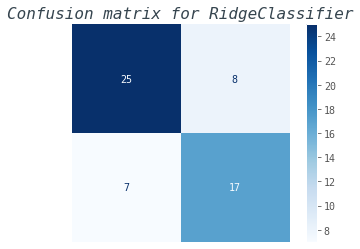

In [30]:
rc = RidgeClassifier()

model=rc.fit(X_train_res, y_train_res)
rcpred = rc.predict(X_test)
print("\n")
print(classification_report(rcpred,y_test))
print("\n")
displr = plot_confusion_matrix(rc, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for RidgeClassifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
model_dataframe = pd.DataFrame(data=[['Ridge Classifier', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])



              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.75      0.72      0.73        25

    accuracy                           0.77        57
   macro avg       0.77      0.77      0.77        57
weighted avg       0.77      0.77      0.77        57





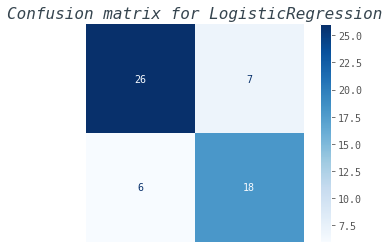

In [31]:
lr = LogisticRegression(max_iter=2000,penalty='l2')

model=lr.fit(X_train_res, y_train_res)
lrpred = lr.predict(X_test)
print("\n")
print(classification_report(lrpred,y_test))
print("\n")
displr = plot_confusion_matrix(lr, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for LogisticRegression', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['Logistic Regression', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.88      0.71      0.78        41
           1       0.50      0.75      0.60        16

    accuracy                           0.72        57
   macro avg       0.69      0.73      0.69        57
weighted avg       0.77      0.72      0.73        57





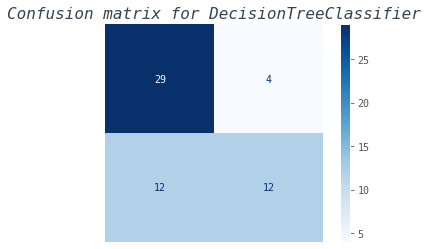

In [32]:
dt = DecisionTreeClassifier()

model= dt.fit(X_train_res, y_train_res)
dtpred = dt.predict(X_test)
print("\n")
print(classification_report(dtpred,y_test))
print("\n")
conf = plot_confusion_matrix(dt, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for DecisionTreeClassifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['DecisionTree Classifier', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.88      0.71      0.78        41
           1       0.50      0.75      0.60        16

    accuracy                           0.72        57
   macro avg       0.69      0.73      0.69        57
weighted avg       0.77      0.72      0.73        57





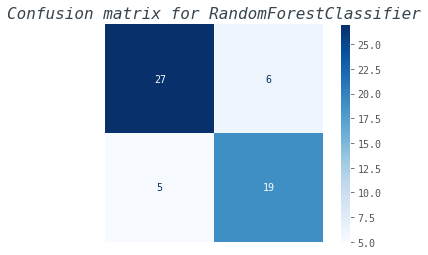

In [33]:
rfc = RandomForestClassifier(random_state=42)

model= rfc.fit(X_train_res, y_train_res)
rfcpred = dt.predict(X_test)
print("\n")
print(classification_report(rfcpred, y_test))
print("\n")
conf = plot_confusion_matrix(rfc, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for RandomForestClassifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['Random Forest Classifier', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.82      0.79      0.81        34
           1       0.71      0.74      0.72        23

    accuracy                           0.77        57
   macro avg       0.76      0.77      0.76        57
weighted avg       0.77      0.77      0.77        57





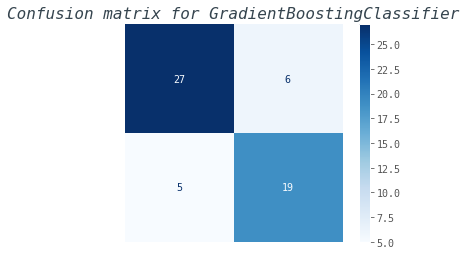

In [34]:
gbm=GradientBoostingClassifier()

model= gbm.fit(X_train_res, y_train_res)
gbmpred = gbm.predict(X_test)
print("\n")
print(classification_report(gbmpred, y_test))
print("\n")
conf = plot_confusion_matrix(rfc, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for GradientBoostingClassifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['GradientBoostingClassifier', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.79      0.76      0.78        34
           1       0.67      0.70      0.68        23

    accuracy                           0.74        57
   macro avg       0.73      0.73      0.73        57
weighted avg       0.74      0.74      0.74        57





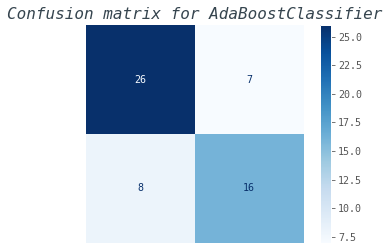

In [35]:
ada = AdaBoostClassifier()

model = ada.fit(X_train_res, y_train_res)
adapred = ada.predict(X_test)
print("\n")
print(classification_report(adapred, y_test))
print("\n")
conf = plot_confusion_matrix(ada, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for AdaBoostClassifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['AdaBoostClassifier', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.75      0.72      0.73        25

    accuracy                           0.77        57
   macro avg       0.77      0.77      0.77        57
weighted avg       0.77      0.77      0.77        57





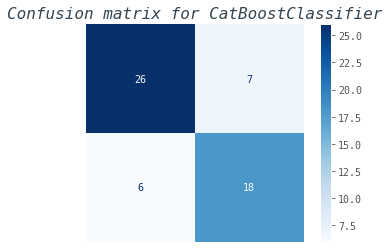

In [36]:
cbc = CatBoostClassifier(silent=True)

model = cbc.fit(X_train_res, y_train_res)
cbcpred = cbc.predict(X_test)
print("\n")
print(classification_report(cbcpred, y_test))
print("\n")
conf = plot_confusion_matrix(cbc, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for CatBoostClassifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['CatBoostClassifier', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.94      0.78      0.85        40
           1       0.62      0.88      0.73        17

    accuracy                           0.81        57
   macro avg       0.78      0.83      0.79        57
weighted avg       0.85      0.81      0.81        57





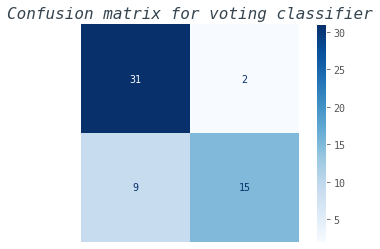

In [37]:
clf1 = RandomForestClassifier(random_state=42)
clf2 = GradientBoostingClassifier()

vc = VotingClassifier(estimators=[('rfc', clf1), ('gbc', clf2)], voting='hard')
model = vc.fit(X_train_res, y_train_res)

vcpred = vc.predict(X_test)
print("\n")
print(classification_report(vcpred,y_test))
print("\n")
conf = plot_confusion_matrix(vc, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for voting classifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['Voting Classifier (HARD)', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)



              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.71      0.77      0.74        22

    accuracy                           0.79        57
   macro avg       0.78      0.79      0.78        57
weighted avg       0.79      0.79      0.79        57





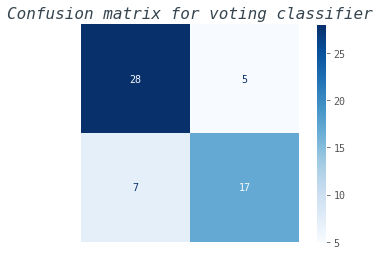

In [38]:
clf1 = RandomForestClassifier(random_state=42) 
clf2 = GradientBoostingClassifier()

vc = VotingClassifier(estimators=[('rfc', clf1), ('gbc', clf2)], voting='soft')
model = vc.fit(X_train_res, y_train_res)

vcpred = vc.predict(X_test)
print("\n")
print(classification_report(vcpred,y_test))
print("\n")
conf = plot_confusion_matrix(vc, X_test, y_test,cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for voting classifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')
#-----------------------------
train_test_dataframe = pd.DataFrame(data=[['Voting Classifier (SOFT)', model.score(X_train_res, y_train_res), model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
model_dataframe = model_dataframe.append(train_test_dataframe, ignore_index=True)

In [39]:
model_dataframe = model_dataframe.sort_values('Test Score', ascending=False).reset_index(drop=True)
model_dataframe

,Model Name,Train Score,Test Score
0,Random Forest Classifier,0.995968,0.807018
1,Voting Classifier (HARD),0.971774,0.807018
2,Voting Classifier (SOFT),0.991935,0.789474
3,Logistic Regression,0.758065,0.771930
4,GradientBoostingClassifier,0.931452,0.771930
5,CatBoostClassifier,0.903226,0.771930
6,Ridge Classifier,0.737903,0.736842
7,AdaBoostClassifier,0.842742,0.736842
8,DecisionTree Classifier,0.995968,0.719298


*Dataframe with Test Score accuracy*

In [40]:
bar_df = go.Bar(x=model_dataframe['Test Score'], y=model_dataframe['Model Name'], orientation='h', opacity=0.7, marker=dict(color=color_library[2]))
data = [bar_df]
layout = go.Layout(title='Models sorted by Test Score accuracy', xaxis={'title':'Test Score Accuracy'}, yaxis={'title':'Models'},
                   paper_bgcolor='#F4F2F0',
                   plot_bgcolor='#F4F2F0')
figure = go.Figure(data=data, layout=layout)

fig.update_layout(paper_bgcolor='#F4F2F0',
                  plot_bgcolor='#F4F2F0',
                  title_font_size=28,
                  font_family="monospace")

figure.show(renderer='colab')

# Fine-tuning ⌨️

In [41]:
def timer(start_time=None):
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#n_estimators = [int(x) for x in np.linspace(start=100, stop=900, num=100)]
#max_depth = [int(x) for x in np.linspace(start=5, stop=15, num=3)]
#min_samples_split = [int(x) for x in np.linspace(start=2, stop=6, num=2)]
params = {
    'n_estimators': [450, 475, 485, 500, 510, 525, 550],
    'max_depth': [ 9, 11, 12, 13, 14, 15],
    'min_samples_split': [1, 2,3, 4]
}

folds = 10
model = RandomForestClassifier()
kf = KFold(n_splits=folds, shuffle=True, random_state=1)
gridsearch = GridSearchCV(model, param_grid=params, scoring="accuracy", n_jobs=-1, cv=kf.split(X_train_res,y_train_res), verbose=3)

start_time = timer(None)
gridsearch.fit(X_train_res,y_train_res)
timer(start_time)


Fitting 10 folds for each of 168 candidates, totalling 1680 fits

 Time taken: 0 hours 16 minutes and 24.26 seconds.


In [42]:
#print('\n All results:')
#print(gridsearch.cv_results_)
print('\n')
print('*'*80)
print('*'*80)
print('\n Best Estimator:')
print(gridsearch.best_estimator_)
print('\n')
print('*'*80)
print('*'*80)
print('\n Best hyperparameters:')
print(gridsearch.best_params_)



********************************************************************************
********************************************************************************

 Best Estimator:
RandomForestClassifier(max_depth=15, n_estimators=510)


********************************************************************************
********************************************************************************

 Best hyperparameters:
{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 510}


https://stats.stackexchange.com/questions/558060/range-of-values-for-hyperparameter-fine-tuning-in-random-forest-classification



              precision    recall  f1-score   support

           0       0.85      0.82      0.84        34
           1       0.75      0.78      0.77        23

    accuracy                           0.81        57
   macro avg       0.80      0.80      0.80        57
weighted avg       0.81      0.81      0.81        57





,Model Name,Train Score,Test Score
0,RandomForestClassifier,0.995968,0.807018


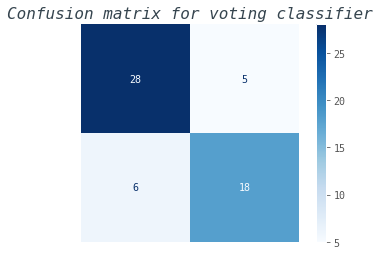

In [51]:
classification_model = RandomForestClassifier(n_estimators= 510,     # default=100, The number of trees in the forest.
                                              max_depth= 15,         #  default=None, The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
                                              min_samples_split= 2)  # default=2, The minimum number of samples required to split an internal node

model = classification_model.fit(X_train_res, y_train_res)
y_pred = classification_model.predict(X_test)

print("\n")
print(classification_report(y_pred ,y_test))
print("\n")
conf = plot_confusion_matrix(classification_model , X_test, y_test, cmap=plt.cm.Blues , values_format='d')
plt.title('Confusion matrix for voting classifier', fontsize=16, fontweight=10, color=color_library[2], style='italic')
plt.axis('off')

final_model_dataframe = pd.DataFrame(data=[['RandomForestClassifier', classification_model.score(X_train_res, y_train_res), classification_model.score(X_test,y_test)]], columns=['Model Name', 'Train Score', 'Test Score'])
final_model_dataframe

# Interpretability ⚙️

SHAP — which stands for SHapley Additive exPlanations — is probably the state of the art in Machine Learning explainability. This algorithm was first published in 2017 by Lundberg and Lee and it is a brilliant way to reverse-engineer the output of any predictive algorithm.
In a nutshell, SHAP values are used whenever you have a complex model (could be a gradient boosting, a neural network, or anything that takes some features as input and produces some predictions as output) and you want to understand what decisions the model is making. 


---


[Original paper about SHAP value](https://arxiv.org/abs/1705.07874)



REFERENCE: [https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)

In [49]:
X_train_res.loc[[1]]

,final_worth,age,country_China,country_Other countries,country_Taiwan,country_United Kingdom,country_United States,city_Beijing,city_New York,city_Other cities,city_San Francisco,city_Shenzhen,city_Taipei,self_made_False,self_made_True,status_D,status_E,status_N,status_U,gender_Female,gender_Male
1,-0.639651,1.867675,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [52]:
import shap 
explainer = shap.TreeExplainer(classification_model) ### USE GOOGLE COLAB TO VIEW
shap_values = explainer.shap_values(X_train_res.loc[[1]])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train_res.loc[[1]])

In [46]:
X_train_res.loc[[20]]

,final_worth,age,country_China,country_Other countries,country_Taiwan,country_United Kingdom,country_United States,city_Beijing,city_New York,city_Other cities,city_San Francisco,city_Shenzhen,city_Taipei,self_made_False,self_made_True,status_D,status_E,status_N,status_U,gender_Female,gender_Male
20,-0.639651,0.721472,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [53]:
shap_values = explainer.shap_values(X_train_res.loc[[20]]) ### USE GOOGLE COLAB TO VIEW
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train_res.loc[[20]])

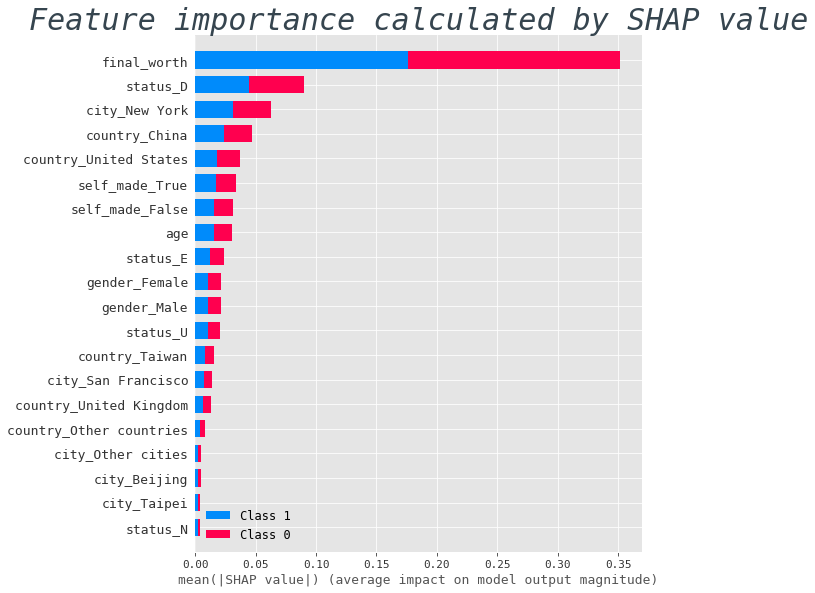

In [48]:
plt.title('Feature importance calculated by SHAP value',fontsize=30, fontweight=10, color=color_library[2], style='italic')
shap.summary_plot(shap_values, X_train) ### USE GOOGLE COLAB TO VIEW